# Udacity Machine Learning Capstone Project
## Image Classification on the Yelp! Dataset using CNN and Transfer learning
** Part 4: Prototype 'Yelp!' application **

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from matplotlib import pyplot as plt
import os
from time import time
import cv2
import glob
from collections import Counter
import time

from keras.applications import VGG19
from keras.models import Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json, model_from_yaml

Using TensorFlow backend.


## Load all architectures

In [2]:
# Load 'Food' model architecture
yaml_file = open('./final_model/model_food.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model_food = model_from_yaml(loaded_model_yaml)
model_food.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_99 (Activation)       (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [3]:
# Load 'Drink' model architecture
yaml_file = open('./final_model/model_drink.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model_drink = model_from_yaml(loaded_model_yaml)
model_drink.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [4]:
# Load 'Environment' model architecture
yaml_file = open('./final_model/model_env.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model_env = model_from_yaml(loaded_model_yaml)
model_env.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 600, 400, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 300, 200, 64)  9472        input_2[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 300, 200, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 300, 200, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

## Load all weights

In [5]:
# Load weights to models
model_food.load_weights('./final_weights/weights.best.food_resnet50.hdf5')
model_drink.load_weights('./final_weights/weights.best.drinks_resnet50.hdf5')
model_env.load_weights('./final_weights/weights.best.env_resnet50.hdf5')

## Define all required functions

In [ ]:
# Function to convert paths to acceptable tensors
from keras.preprocessing import image

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(600, 400))
    # convert PIL.Image.Image type to 3D tensor with shape (600, 400, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 600, 400, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [7]:
# Function to convert paths to acceptable tensors
from keras.preprocessing import image

def path_to_tensor_2(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor_2(img_paths):
    list_of_tensors = [path_to_tensor_2(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [8]:
# Function to convert images into tensors
def image_to_tensor(img):
    x = image.img_to_array(img)
    img = cv2.resize(x, (400,600))
    return np.expand_dims(img, axis = 0)
def image_to_tensor_2(img):
    x = image.img_to_array(img)
    img = cv2.resize(x, (224,224))
    return np.expand_dims(img, axis = 0)

In [9]:
# Get "Environment" labels
def get_env_label(label):
    if (label==0):
        return "Food"
    elif (label==1):
        return "Drink"
    elif (label==2):
        return "Inside"
    elif (label==3):
        return "Outside"
    elif (label==4):
        return "Menu"

In [10]:
# Get "Food" labels
def get_food(label):
    
    if (label == 0):
        return 'Noodles'
    elif (label == 1):
        return 'Salad'
    elif (label == 2):
        return 'Fries'
    elif (label == 3):
        return 'Tacos'
    elif (label == 4):
        return 'Burger'
    elif (label == 5):
        return 'Steak'
    elif (label == 6):
        return 'Ice Cream'
    elif (label == 7):
        return 'Pizza'

In [11]:
# Get "drink" labels
def get_drink(label):
    if (label==0):
        return "Beer"
    elif (label==1):
        return "Milk Shake"
    elif (label==2):
        return "Wine"

In [36]:
# Function to process videos and write to an output file
def get_prediction_video(input_file, output_file):
    
    cap = cv2.VideoCapture(input_file)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file,fourcc, 20.0, (640,480))
    
    while (cap.isOpened()):
        ret, frame = cap.read()
        if (ret == True):
            frame = cv2.resize(frame, (640,480))
            # Predict "Environemnt" label
            env = np.argmax(model_env.predict(image_to_tensor(frame).astype('float32')/255))
            
            # If "Food", predict the type of food and display label onto frame
            if (env==0):
                food = np.argmax(model_food.predict(image_to_tensor_2(frame).astype('float32')/255))
                cv2.putText(frame, "I see " + get_env_label(env), 
                            (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,39,32), 2)
                cv2.putText(frame, "I see " + get_food(food),
                        (250,450), cv2.FONT_HERSHEY_SIMPLEX, 1, (52,32,238), 2)
            # If "Drink", predict the type of drink and display label onto frame
            elif (env==1):
                drink = np.argmax(model_drink.predict(image_to_tensor_2(frame).astype('float32')/255))
                cv2.putText(frame, "I see a " + get_env_label(env),
                        (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,39,32), 2)
                cv2.putText(frame, "I see " + get_drink(drink),
                        (250,450), cv2.FONT_HERSHEY_SIMPLEX, 1, (52,32,238), 2)
            # If 'Inside' or 'Outside', display label onto frame
            elif (env==2 or env==3):
                cv2.putText(frame, "I am " + get_env_label(env),
                        (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,39,32), 2)
            # If 'menu', display label onto frame
            elif (env==4):
                cv2.putText(frame, "I see a " + get_env_label(env),
                        (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,39,32), 2)
            # Write frame to file
            out.write(frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    print "Done"

In [13]:
# Function to predict images
def get_prediction(path):
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (height, width, channels) = np.shape(cv_rgb)

    env = np.argmax(model_env.predict(path_to_tensor(path).astype('float32')/255))
    plt.imshow(cv_rgb)
    
    #
    if (env==0):
        food = np.argmax(model_food.predict(path_to_tensor_2(path).astype('float32')/255))
        plt.text(height*0.1, width*0.1, "I see " + get_env_label(env),
                bbox={'facecolor':'white', 'alpha':0.75, 'pad':0.02*height}, fontsize=0.03*width)
        plt.text(width*0.4, height*0.9, "I see " + get_food(food),
                bbox={'facecolor':'white', 'alpha':0.75, 'pad':0.02*height}, fontsize=0.03*width)
    elif (env==1):
        drink = np.argmax(model_drink.predict(path_to_tensor_2(path).astype('float32')/255))
        plt.text(height*0.1, width*0.1, "I see a " + get_env_label(env),
                bbox={'facecolor':'white', 'alpha':0.75, 'pad':0.02*height}, fontsize=0.03*width)
        plt.text(width*0.4, height*0.9, "I see " + get_drink(drink),
                bbox={'facecolor':'white', 'alpha':0.75, 'pad':0.02*height}, fontsize=0.03*width)
    elif (env==2 or env==3):
        plt.text(height*0.1, width*0.1, "I am " + get_env_label(env),
                bbox={'facecolor':'white', 'alpha':0.75, 'pad':0.02*height}, fontsize=0.03*width)
    elif (env==4):
        plt.text(height*0.1, width*0.1, "I see a " + get_env_label(env),
                bbox={'facecolor':'white', 'alpha':0.75, 'pad':0.02*height}, fontsize=0.03*width)
    
    plt.show()

## Make certain predictions on "Yelp" dataset

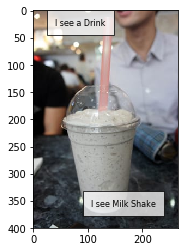

In [14]:
get_prediction('./photos/AIm6ZLuftGWU6dqUanZa0w.jpg') # Actual label: Drink, Milkshake

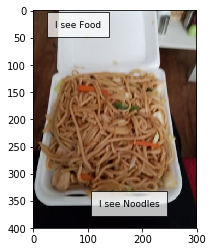

In [15]:
get_prediction('./photos/63P6XCqxnyY9zOAGVznSGg.jpg') # Actual label: Food, Noodles

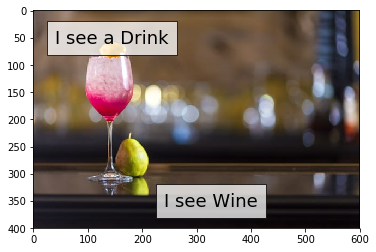

In [16]:
get_prediction('./photos/7YXLvT2b-f8ZsymHeFXb-Q.jpg') # Actual label: Drink, Wine

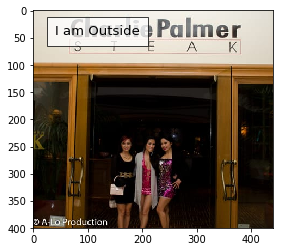

In [17]:
get_prediction('./photos/itdYeVBWEmBRS4qUyB1e8w.jpg') # Actual label: Outside

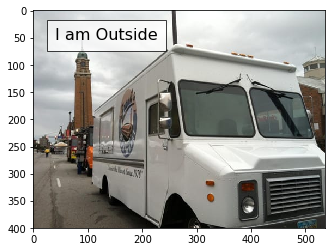

In [18]:
get_prediction('./photos/mSc9_G6fKdwkWH4LRSy2pg.jpg') # Actual label: Outside

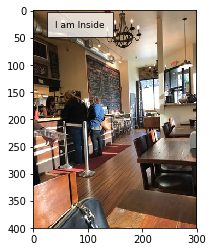

In [19]:
get_prediction('./photos/tPonz74rjcrcm5EHc_w6uw.jpg') # Actual label: Inside

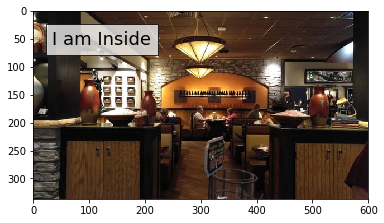

In [20]:
get_prediction('./photos/zTiCkwV8GOAM-ABuvAOlHg.jpg') # Actual label: Inside

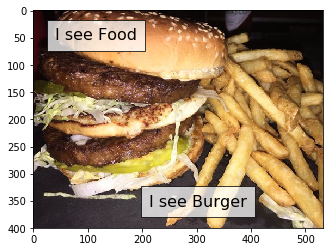

In [21]:
get_prediction('./photos/UKcm-RGgYo0bvVqtvk6LYQ.jpg') # Actual label: Food, Burger or Fries

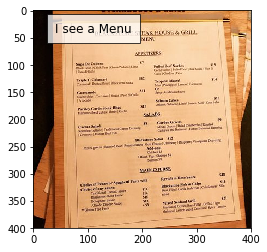

In [22]:
get_prediction('./photos/3hKX-RBghEmdur8q0ZB-xA.jpg') # Actual label: Menu

## Get predictions on a Video file

In [37]:
get_prediction_video(input_file='burger_king.mp4', output_file='output_burger.mp4')

Done
